Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Load Dataset


In [ ]:
df = pd.read_csv('../data/diabetes.csv')
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Preprocess the Data

In [6]:
# Columns that shouldn't have 0 values
cols_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace 0 with NaN
df[cols_to_clean] = df[cols_to_clean].replace(0, np.nan)

# Fill NaN with column means
df.fillna(df.mean(), inplace=True)

df.isnull().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Visualize Correlations

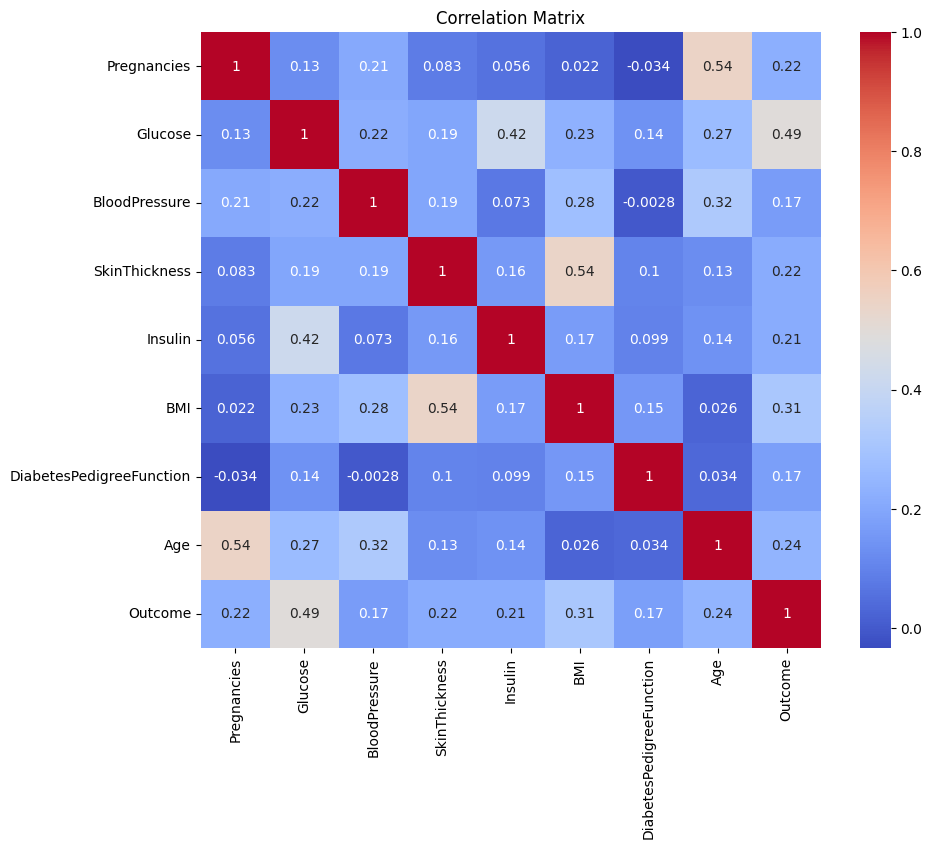

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Train the ML Model

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Separate features & target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
model = XGBClassifier()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.75      0.78        99
           1       0.61      0.71      0.66        55

    accuracy                           0.73       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



Save the Model

In [9]:
import joblib

# Save model to models/ folder
joblib.dump(model, '../models/model.pkl')
print("Model saved to models/model.pkl")


Model saved to models/model.pkl
